In [386]:
import os
from os import listdir
import pandas as pd
path = os.getcwd()
print (listdir(path))

ori_train = pd.read_csv("train.csv")
ori_test = pd.read_csv("test.csv")
train = ori_train.copy()


final_test = ori_test.copy()

# whole = ori_train.append(ori_test).copy()
print (len(train), len(final_test))


['Titanic 1.ipynb', 'Titanic 2.ipynb', 'README.md', 'test.csv', '.ipynb_checkpoints', 'train.csv', '.git', 'submission.csv', 'Titanic 2-backup with RFE.ipynb', 'gender_submission.csv']
891 418


In [387]:
final_test = ori_test.copy()
final_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [388]:
print (train.isna().sum())
#too many NaN for Cabin, maybe drop it later
print (train.Cabin.isna().sum()/len(train.Cabin))

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
0.7710437710437711


U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

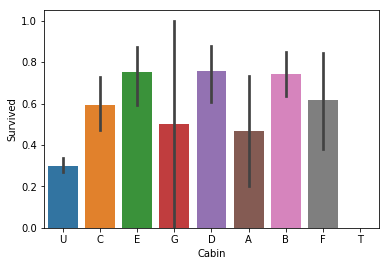

In [389]:
import seaborn as sns
train.Cabin = train.Cabin.fillna("U")
train.Cabin = train.Cabin.apply(lambda x:x[0])
sns.barplot(x = train.Cabin, y = "Survived", data = train)
train.Cabin.value_counts()


some Carbin has a higher survival rate. Online information shows B & C is mostly for first class but also large section on A,D,E used for first class as well. Too many NaN to reflect anything accurate. PClass column would do a better job at reflecting the relationship between class and survivorship.

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Age')

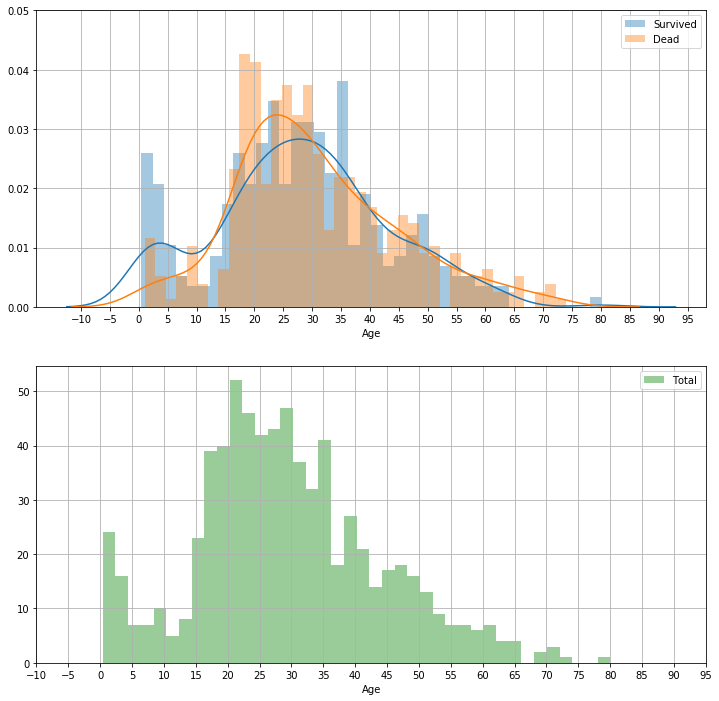

In [390]:
import matplotlib.pyplot as plt
import seaborn as sns
corr  = train[["Age", "Survived", "Sex"]]
# corr = 
corr = corr.dropna()

# print (corr)
fig = plt.figure(figsize = (12,12))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
sns.distplot(corr.Age, hist = 1, label = "Total", ax = ax2, color = "g", kde = 0, bins = 40)
sns.distplot(corr.loc[(corr["Survived"] == 1)].Age, hist = 1, label = "Survived", ax = ax1, bins = 40)
sns.distplot(corr.loc[corr["Survived"] == 0 ].Age, hist = 1, label = "Dead", ax = ax1, bins = 40)
ax1.xaxis.set_ticks(range(-10, 100, 5))
ax2.xaxis.set_ticks(range(-10, 100, 5))
ax1.set_ylim(0,0.05)
ax2.legend()
ax1.legend()
ax2.grid()
ax1.grid()

ax2.set_xlabel("Age")



Age seems to have a little correlation with survival rate, especially the person being really young would drastically increase survivial rate. Therefore won't drop the Age column but will fill the age in somehow instead.

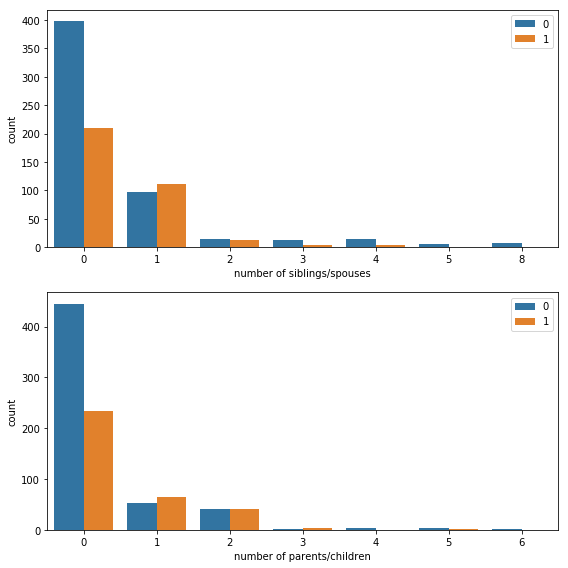

In [391]:
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.countplot(x = "SibSp", hue = "Survived", data = train, ax = ax1)
sns.countplot(x = "Parch", hue = "Survived", data = train, ax= ax2)
ax1.set_xlabel("number of siblings/spouses")
ax2.set_xlabel("number of parents/children")
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
fig.tight_layout()




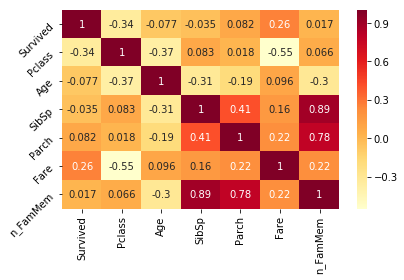

In [392]:
import numpy as np
train["n_FamMem"] = train.SibSp + train.Parch
train["Family_size"] = train["n_FamMem"].apply(lambda x: "alone" if x == 0 else "small" if x <4 else "large")

corr = train.drop(["PassengerId",], axis = 1).corr()
sns.heatmap(corr, cmap = "YlOrRd", annot = True)
plt.tight_layout()
plt.yticks(rotation = 45)

final_test["n_FamMem"] = final_test.SibSp + final_test.Parch
final_test["Family_size"] = final_test["n_FamMem"].apply(lambda x: "alone" if x == 0 else "small" if x <4 else "large")


Text(0.5,0,'family size')

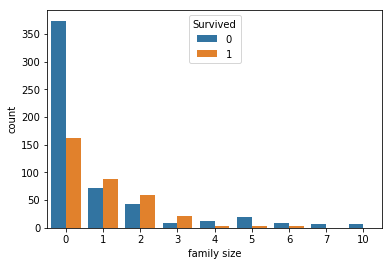

In [393]:
sns.countplot("n_FamMem", hue = "Survived", data = train)
plt.xlabel("family size")

Decided to drop Parch and SibSp because checking logisitic regression feature importance later on noticed that SibSp and Parch dont' make much difference. Also help reduce dimentionality.

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


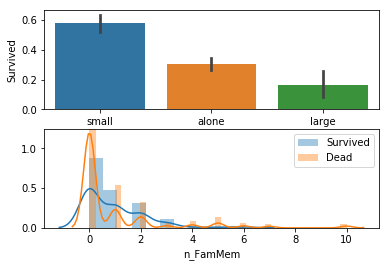

In [394]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.barplot(x = "Family_size", y = "Survived", data = train, ax = ax1)
sns.distplot(train.loc[train["Survived"] == 1].n_FamMem, hist = 1, label = "Survived", ax = ax2)
sns.distplot(train.loc[train["Survived"] == 0].n_FamMem, hist = 1, label = "Dead", ax = ax2)

plt.legend()

In [395]:

def normalise_title(data):
    data["Title"] = data.Name.str.split(",").apply(lambda x:x[1].split(".")[0].strip())
    data.loc[data.Title.str.contains("Ms"), "Title"] = "Miss"
    data.loc[data.Title.str.contains("Mlle"), "Title"] = "Miss"
    data.loc[data.Title.str.contains("Mme"), "Title"] = "Mrs"
    #Master is generally a title given to boys at the 19th Century 、
    # (though some adult still carry that title since earlier days), keep it as kid tend to survive
    # data.loc[data.Title.str.contains("Master"), "Title"] = "Mr"
    data.loc[data.Title.str.contains("Lady"), "Title"] = "Royalty"
    data.loc[data.Title.str.contains("Sir"), "Title"] = "Royalty"
    data.loc[data.Title.str.contains("the Countess"), "Title"] = "Royalty"
    data.loc[data.Title.str.contains("Jonkheer"), "Title"] = "Royalty"
    data.loc[data.Title.str.contains("Don"), "Title"] = "Royalty"
    data.loc[data.Title.str.contains("Capt"), "Title"] = "Military"
    data.loc[data.Title.str.contains("Major"), "Title"] = "Military"
    data.loc[data.Title.str.contains("Col"), "Title"] = "Military"
    return data
train = normalise_title(train)
final_test = normalise_title(final_test)
print (train.Title.value_counts())

Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Military      5
Royalty       5
Name: Title, dtype: int64


In [396]:
def show_fam(data):
    # replace NaN age with their spouse/siblings
    fam = pd.DataFrame(columns = data.columns)
    for i in range(len(data)): 
        if data.at[i, "SibSp"] > 0 and data.at[i, "Parch"] == 0 and pd.isna(data.at[i, "Age"]):
    #         print (pd.isna(data.at[i, "Age"]))
            #can ascertain the companions are spouse or sibling and should have similar age
#             print (data.loc[i, "Name"])
            comp = data[data.Ticket == data.iloc[i].Ticket]
            if pd.notna(comp.Age).any() == True:
                fam = fam.append(comp, ignore_index = True)
    return fam
final_test["Survived"] = 999 # dummy
whole = train.append(final_test, ignore_index = True)[train.columns.tolist()]
fam = show_fam(whole)
fam.shape


(15, 15)

In [397]:
fam

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_FamMem,Family_size,Title
0,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B,C,1,small,Mrs
1,196,1,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B,C,0,alone,Miss
2,1208,999,1,"Spencer, Mr. William Augustus",male,57.0,1,0,PC 17569,146.5208,B78,C,1,small,Mr
3,112,0,3,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,U,C,1,small,Miss
4,241,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,U,C,1,small,Miss
5,335,1,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",female,NaN,1,0,PC 17611,133.6500,U,S,1,small,Mrs
6,661,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,U,S,2,small,Dr
7,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,U,C,1,small,Mr
8,376,1,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,NaN,1,0,PC 17604,82.1708,U,C,1,small,Mrs
9,458,1,1,"Kenyon, Mrs. Frederick R (Marion)",female,NaN,1,0,17464,51.8625,D,S,1,small,Mrs


In [398]:
whole.groupby(["Pclass", "Sex"]).mean()

PassengerId    Survived        Age     SibSp     Parch  \
Pclass Sex                                                              
1      female   689.652778  347.506944  37.037594  0.555556  0.472222   
       male     658.687151  318.368715  41.029272  0.340782  0.279330   
2      female   632.188679  283.396226  27.499223  0.500000  0.650943   
       male     695.976608  368.152047  30.815380  0.327485  0.192982   
3      female   628.393519  333.333333  22.185329  0.791667  0.731481   
       male     645.888438  295.945233  25.962264  0.470588  0.255578   

                     Fare  n_FamMem  
Pclass Sex                           
1      female  109.412385  1.027778  
       male     69.888385  0.620112  
2      female   23.234827  1.150943  
       male     19.904946  0.520468  
3      female   15.324250  1.523148  
       male     12.415462  0.726166

In [399]:
%time
def sibling_age_replace(data):
    # replace NaN age with their spouse/siblings
    for i in range(len(data)):
        if data.at[i, "SibSp"] > 0 and data.at[i, "Parch"] == 0 \
          and pd.isna(data.at[i, "Age"]):
    #         print (pd.isna(data.at[i, "Age"]))
            #can ascertain the companions are spouse or sibling and should have similar age
    #         print (data.loc[i, "Name"])
            comp = data[data.Ticket == data.iloc[i].Ticket]
    #         print (comp)
            mean_age = comp.Age.mean()   
    #         print (mean_age)
            data.at[i, "Age"] = mean_age
    return data

# train = sibling_age_replace(train)
# final_test = sibling_age_replace(final_test)        
whole = sibling_age_replace(whole)
whole[whole.Name.str.contains("Goldenberg")] #example
        


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_FamMem,Family_size,Title
453,454,1,1,"Goldenberg, Mr. Samuel L",male,49.0,1,0,17453,89.1042,C,C,1,small,Mr
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,49.0,1,0,17453,89.1042,C,C,1,small,Mrs


In [400]:
train = whole[whole.Survived != 999]
final_test = whole[whole.Survived == 999].drop("Survived", axis = 1)

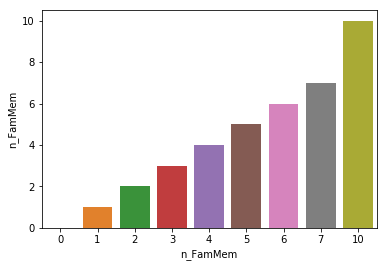

In [401]:
sns.barplot(x = "n_FamMem", y = "n_FamMem", data = whole)

In [402]:
#both are woman, same ticket
train[pd.isna(train.Embarked)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_FamMem,Family_size,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B,NaN,0,alone,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B,NaN,0,alone,Mrs


In [403]:
# print (train.groupby().count_)
train.groupby("Embarked").Fare.describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
C,168.0,59.954144,83.912994,4.0125,13.69795,29.70,78.500025,512.3292
Q,77.0,13.276030,14.188047,6.7500,7.75000,7.75,15.500000,90.0000
S,644.0,27.079812,35.887993,0.0000,8.05000,13.00,27.900000,263.0000


Both are woman, same ticket number and same Fare price, So I am going to assume they embarked from the same place(probably know each other). Although at first sight it appears that their high fare price suggest they might have embarked from C, searching online revealed that Miss Icard is the maid of Mrs Stone and they boarded the ship at Southampton (https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html).

In [404]:
train.loc[pd.isna(train.Embarked), "Embarked"] = "S"

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [405]:
print (train.Title.value_counts())
group = train.groupby(["Title", "Family_size"])
group.Age.mean()

Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Military      5
Royalty       5
Name: Title, dtype: int64


Title     Family_size
Dr        alone          39.500000
          small          47.000000
Master    large           5.250000
          small           4.033500
Military  alone          53.250000
          small          70.000000
Miss      alone          27.654321
          large          12.000000
          small          15.875000
Mr        alone          32.388316
          large          27.750000
          small          32.681818
Mrs       alone          40.764706
          large          40.000000
          small          35.017045
Rev       alone          44.250000
          small          41.000000
Royalty   alone          37.000000
          small          48.500000
Name: Age, dtype: float64

Average age within each title can differ a lot depending on the family size. Rationalise by the fact that if you are a Miss travelling alone, you probably are an adult, however if you are travelling with family, then you probably are kids. Mrs will small family size also tends to be younger than on with large family size which make sense. 

In [406]:
#split into train test set before applying mean imputation to avoid information leakage.
from sklearn.utils import shuffle

split_idx = int(len(train)*0.85)
train = shuffle(train)

wholeset = train.copy()
test = train.iloc[split_idx:,]
train = train.iloc[:split_idx,]


def impute_age(data):
    data.Age = data.groupby(["Title", "Family_size"]).Age.apply(lambda group: group.fillna(group.mean()))
    #special handling if there is still NaN
    data.Age = data.groupby('Title').Age.apply(lambda group: group.fillna(group.mean())) 
    return data

wholeset, train, test, final_test = [impute_age(data) for data in [wholeset, train, test, final_test]]

# wholeset.Age = wholeset.groupby(["Title", "Family_size"]).Age.apply(lambda group: group.fillna(group.mean()))
# train.Age = train.groupby(["Title", "Family_size"]).Age.apply(lambda group: group.fillna(group.mean()))
# test.Age = test.groupby(["Title", "Family_size"]).Age.apply(lambda group: group.fillna(group.mean()))
# final_test.Age = final_test.groupby(["Title", "Family_size"]).Age.apply(lambda group: group.fillna(group.mean()))

# wholeset.Age = wholeset.groupby('Title').Age.apply(lambda group: group.fillna(group.mean()))
# train.Age = train.groupby('Title').Age.apply(lambda group: group.fillna(group.mean()))
# test.Age = test.groupby('Title').Age.apply(lambda group: group.fillna(group.mean()))
# final_test.Age = final_test.groupby('Title').Age.apply(lambda group: group.fillna(group.mean()))

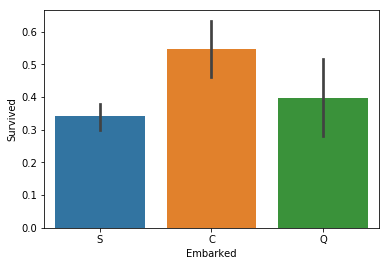

In [407]:
train.Embarked.value_counts()
sns.barplot(x = "Embarked", y = "Survived", data = train)

Embarkment place seems to make a difference so keep it.

In [408]:
print (any(pd.isna(train).any())) # double check
print (any(pd.isna(test).any()))
print (any(pd.isna(final_test).any()))
print (any(pd.isna(wholeset).any()))

False
False
True
False


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


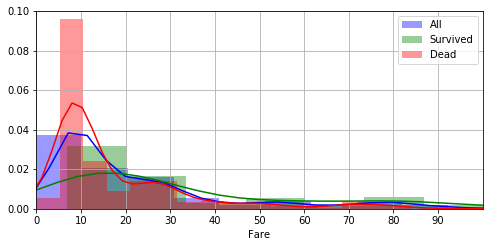

In [409]:
# sns.barplot("Pclass", "Survived", data = train)
# sns.distplot(corr.loc[corr["Survived"] == 1].Age, hist = 1, label = "Survived", ax = ax1)
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
sns.distplot(train.Fare, label = "All", ax = ax1, color = "b")
sns.distplot(train.loc[train.Survived == 1].Fare, label = "Survived", ax = ax1, color = "g")
sns.distplot(train.loc[train.Survived == 0].Fare, label = "Dead", ax = ax1, color = "r")
# ax2.set_yticks(range(0,300,50))
ax1.set_xlim(0,100)
# ax2.set_xlim(0,100)
ax1.legend()
# ax2.legend()
ax1.grid()
# ax2.grid()
ax1.set_xticks(range(0,100,10))
ax1.set_ylim(0,0.1)
# ax2.set_xticks(range(0,100,10))
plt.show()


it does seems that buying a cheap ticket has a highest chance of death

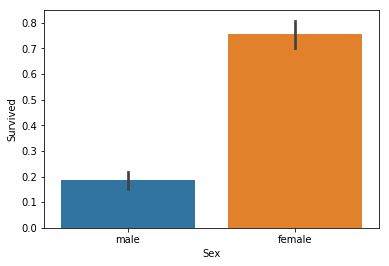

In [410]:
sns.barplot("Sex", "Survived", data = train)

In [411]:
train["Age_group"] = train.Age.apply(lambda x: "child" if x < 16 else "young adult" if x <33 else "adult")
test["Age_group"] = test.Age.apply(lambda x: "child" if x < 16 else "young adult" if x <33 else "adult")
final_test["Age_group"] = final_test.Age.apply(lambda x: "child" if x < 16 else "young adult" if x <33 else "adult")
wholeset["Age_group"] = wholeset.Age.apply(lambda x: "child" if x < 16 else "young adult" if x <33 else "adult")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,n_FamMem,Family_size,Title,Age_group
410,411,0,3,"Sdycoff, Mr. Todor",male,32.394422,0,0,349222,7.8958,U,S,0,alone,Mr,young adult
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.000000,1,0,11755,39.6000,A,C,1,small,Royalty,adult
843,844,0,3,"Lemberopolous, Mr. Peter L",male,34.500000,0,0,2683,6.4375,U,C,0,alone,Mr,adult
574,575,0,3,"Rush, Mr. Alfred George John",male,16.000000,0,0,A/4. 20589,8.0500,U,S,0,alone,Mr,young adult
89,90,0,3,"Celotti, Mr. Francesco",male,24.000000,0,0,343275,8.0500,U,S,0,alone,Mr,young adult


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


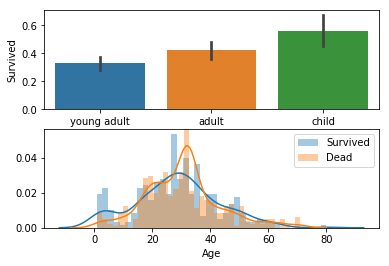

In [412]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.barplot(x = "Age_group", y = "Survived", data = train, ax = ax1)
sns.distplot(train.loc[train["Survived"] == 1].Age, hist = 1, label = "Survived", ax = ax2, bins = 40)
sns.distplot(train.loc[train["Survived"] == 0].Age, hist = 1, label = "Dead", ax = ax2, bins = 40)
plt.legend()



In [413]:
final_test[pd.isna(final_test.Fare)]
final_test.groupby(["Pclass", "Embarked", "Age_group"]).mean()
final_test.Fare.fillna("16.977254", inplace = True)


In [414]:
def drop_and_cat(data, contain_labels = True):
    y = data.Survived if contain_labels == True else None
    data.drop(["Cabin", "PassengerId", "Ticket", "Name", "SibSp","Parch", ], axis = 1, inplace = True)
    data.drop(["Survived",], axis = 1, inplace = True) if contain_labels == True else data
    X = pd.get_dummies(data, columns = ["Sex", "Embarked", "Age_group", "Family_size", "Title"])
    return (X, y)


wholeset_X, wholeset_y = drop_and_cat(wholeset)

combined_set = train.append(test)
combined_X, combined_y = drop_and_cat(combined_set)

test_X = combined_X.iloc[split_idx:]
train_X = combined_X.iloc[:split_idx]

test_y = combined_y.iloc[split_idx:]
train_y = combined_y.iloc[:split_idx]

final_test_X, _ = drop_and_cat(final_test, contain_labels = False)


assert len(train_X.columns) == len(test_X.columns) == len(final_test_X.columns) == len(wholeset_X.columns)
print ("Number of features: " + str(len(train_X.columns)))

Number of features: 23


In [169]:
# def drop_col(data):

# wholeset.drop(["Cabin", "PassengerId", "Ticket", "Name", "SibSp","Parch", ], axis = 1, inplace = True)
# wholeset_X = wholeset.drop(["Survived",], axis = 1)
# wholeset_y = wholeset.Survived

# train.drop(["Cabin", "PassengerId", "Ticket", "Name", "SibSp","Parch", ], axis = 1, inplace = True)
# train_X = train.drop(["Survived",], axis = 1)
# train_y = train.Survived

# test.drop(["Cabin", "PassengerId", "Ticket", "Name", "SibSp","Parch", ], axis = 1, inplace = True)
# test_X = test.drop(["Survived",], axis = 1)
# test_y = test.Survived

# final_test.drop(["Cabin", "PassengerId", "Ticket", "Name", "SibSp","Parch", ], axis = 1, inplace = True)
# # test_X = test.drop(["Survived",], axis = 1) #shouldnt work



# assert len(train_X.columns) == len(test_X.columns) == len(final_test.columns) == len(wholeset_X.columns)
# train_X.columns


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'n_FamMem', 'Family_size',
       'Title', 'Age_group'],
      dtype='object')

In [170]:
# # X = pd.get_dummies(X, columns = ["Title", "Sex", "Age", "SibSp", "Parch", "Family_size", "Embarked"])


# wholeset_X = pd.get_dummies(wholeset_X, columns = ["Sex", "Embarked", "Age_group", "Family_size", "Title"])

# combined_X = train_X.append(test_X)
# combined_X = pd.get_dummies(combined_X, columns = ["Sex", "Embarked", "Age_group", "Family_size", "Title"])

# test_X = combined_X.iloc[split_idx:]
# train_X = combined_X.iloc[:split_idx]

# final_test_X =  pd.get_dummies(final_test, columns = ["Sex", "Embarked", "Age_group", "Family_size", "Title"])

# # train_X = pd.get_dummies(train_X, columns = ["Sex", "Embarked", "Age_group", "Family_size", "Title"])
# # test_X = pd.get_dummies(test_X, columns = ["Sex", "Embarked", "Age_group", "Family_size", "Title"])
# # X.drop(["Family_size"], axis = 1, inplace = True)
# # X = pd.get_dummies(X, columns = ["Title", "Sex", "Age", "SibSp", "Parch", "Embarked"])

# # X.drop(["Family_size", "SibSp", "Parch"], axis = 1, inplace = True)
# # X = pd.get_dummies(X, columns = ["Title", "Sex", "Age", "Embarked"])
# print ("Number of features: " + str(len(train_X.columns)))

Number of features: 23


In [172]:
# X.drop("Fare", axis = 1, inplace = True)

from sklearn import preprocessing

columns = train_X.columns
# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 100)
wholeset_X = preprocessing.scale(wholeset_X)
train_X = preprocessing.scale(train_X)
test_X = preprocessing.scale(test_X)
final_test_X = preprocessing.scale(final_test_X)




In [173]:
import warnings
def GridSearch(estimator, params):
    with warnings.catch_warnings():
#         estimator.fit(X, y)
         
        print ("original CV score:" + str(cross_val_score(estimator, train_X, train_y, cv = 3).mean()))
#         print ("original test score:" + str(estimator.fit(train_X, train_y).score(test_X, test_y)))
        warnings.simplefilter("ignore", category=UserWarning)
        warnings.simplefilter("ignore", category=DeprecationWarning)
        clf_gs = GridSearchCV(estimator, params, refit = True, cv = 3)
        clf_gs.fit(train_X, train_y)
    print ("CV score after grid search: " + str(clf_gs.best_score_))
    print ("test score after grid search: " + str(clf_gs.score(test_X, test_y)))
    return clf_gs.best_estimator_
def feat_imp(coef):
    feature_im = pd.DataFrame(data = coef, columns = ["importance"], index = columns).sort_values("importance", ascending = False)
    print (feature_im.head(), feature_im.tail())
    return feature_im    

In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(C = 1, n_jobs = -1)

# print (cross_val_score(clf, X, y, cv = 5).mean())
params = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
         "solver": ["liblinear", "lbfgs"], 
         "max_iter": [100, 1000]}

new_clf = GridSearch(clf, params)
feat_im = feat_imp(new_clf.coef_[0])
print (new_clf)
print(clf)




original CV score:0.8123993558776167


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


CV score after grid search: 0.8190224570673712
test score after grid search: 0.8507462686567164
              importance
Sex_female      0.272175
Title_Master    0.180978
Title_Mrs       0.177862
Title_Miss      0.163921
Fare            0.154581                    importance
n_FamMem            -0.111978
Family_size_large   -0.235659
Sex_male            -0.272175
Title_Mr            -0.319532
Pclass              -0.356267
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [175]:
from sklearn.svm import SVC
svc = SVC(C = 1)
# svc.fit(X, y)
# print (cross_val_score(svc, X, y, cv = 5).mean())

params = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
         "kernel": ["linear", "rbf", "poly"],}

new_svc = GridSearch(svc, params)
if new_svc.kernel == "linear":
    feat_im = feat_imp(new_svc.coef_[0])
print (new_svc)

original CV score:0.812388899345421
CV score after grid search: 0.8137384412153237
test score after grid search: 0.8507462686567164
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [176]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs = -1)
# print (cross_val_score(knn, X, y, cv = 5).mean())

params = {"leaf_size": [1, 3, 10 ,30],
         "n_neighbors": [5 ,7 , 9, 11, 13],}

new_knn = GridSearch(knn, params)
print (new_knn)

original CV score:0.8203515486124182
CV score after grid search: 0.8203434610303831
test score after grid search: 0.8432835820895522
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')


In [177]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='adam', alpha=1e-3,hidden_layer_sizes=(100,), random_state=100,learning_rate_init = 0.01 )
# print (cross_val_score(nn, X, y, cv = 5).mean())

params = {"hidden_layer_sizes": [(10,), (100,), (50,), (50,50),],
         "activation": ["relu", "logistic"], 
          "alpha": [0.00001, 0.0001, 0.001 , 0.01, 1], 
          "learning_rate": ["constant", "invscaling", "adaptive"],
          }

new_nn = GridSearch(nn, params)
print (new_nn)

original CV score:0.811087061087061
CV score after grid search: 0.8348745046235139
test score after grid search: 0.835820895522388
MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50), learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=100,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


In [196]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs = -1)
rfc.fit(train_X, train_y)
params = {"max_depth": [None, 3, 5],
         "min_samples_leaf": [1, 5, 10], 
          "n_estimators": [10, 50 , 100, 500],
          "min_samples_split": [2, 5, 10],
          }

new_rfc = GridSearch(rfc, params)
print (new_rfc)


original CV score:0.793917435221783
CV score after grid search: 0.8256274768824307
test score after grid search: 0.8432835820895522


In [178]:
%%time
from xgboost import XGBClassifier
xgb = XGBClassifier(n_jobs = -1, n_estimators = 600, learning_rate = 0.2, max_depth = 3, colsample_bytree = 0.8, colsample_bylevel = 0.5)

# xgb.fit(train_X, train_y)
# print (xgb.score(val_X, val_y))

params = {"max_depth": [3,4,5,6],
         "learning_rate": [0.05, 0.1, 0.2, 0.5], 
          "n_estimators": [50, 100 ,600,],
          "subsample": [0.6, 0.8, 1.0],
          "colsample_bytree": [0.6, 0.8, 1.0],
          "colsample_bylevel": [0.6, 0.8, 1.0]
          }

new_xgb = GridSearch(xgb, params)
print (new_xgb)


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


original CV score:0.809816592425288
CV score after grid search: 0.8441215323645971
test score after grid search: 0.8432835820895522
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)
CPU times: user 21min 44s, sys: 8.91 s, total: 21min 53s
Wall time: 2min 49s


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [179]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier([("log", clf), ("mlp", nn), ("xgb", xgb), ("svc", svc), ("knn", knn)], n_jobs = -1, voting = "hard")
vc.fit(train_X, train_y)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    print (cross_val_score(vc, train_X, train_y, cv = 3).mean())
#     print(vc.score(test_X, test_y))
    print (cross_val_score(vc, test_X, test_y, cv = 3).mean())

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


0.8203358638141247
0.8436026936026936


In [180]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier([("log", new_clf), ("mlp", new_nn), ("xgb", new_xgb), ("svc", new_svc), ("knn", new_knn)], n_jobs = -1, voting = "hard")
vc.fit(train_X, train_y)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    print (cross_val_score(vc, train_X, train_y, cv = 3).mean())
#     print(vc.score(test_X, test_y))
    print (cross_val_score(vc, test_X, test_y, cv = 3).mean())
    

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


0.821658615136876
0.8363636363636364


In [181]:
cross_val_score(vc, wholeset_X, wholeset_y, cv = 3).mean()

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/hom

0.8204264870931538

In [182]:
vc.fit(wholeset_X, wholeset_y)
print(vc.score(test_X, test_y))


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


0.8656716417910447


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [183]:
cross_val_score(new_xgb, wholeset_X, wholeset_y, cv = 3).mean()

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8237934904601572

In [184]:
preds = vc.predict(final_test_X)

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [185]:
# my_submission = pd.DataFrame({'PassengerId': ori_test.PassengerId, 'Survived': preds})
# # you could use any filename. We choose submission here
# my_submission.to_csv('submission.csv', index=False)

In [186]:
from sklearn.feature_selection import RFECV

def feat_sel(estimator):
    print (estimator)
    rfe = RFECV(estimator, step = 1, cv = 3, n_jobs = -1)
#     estimator.fit(train_X, train_y)
#     print (estimator.score(val_X, val_y))
    print (cross_val_score(estimator, train_X, train_y, cv = 3).mean())
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        warnings.simplefilter("ignore", category=UserWarning)
        rfe.fit(train_X, train_y)
        print (rfe.score(test_X, test_y))
    for i in range(len(columns)):
        if rfe.support_[i] == True:
            print (columns[i])  
    return rfe
            
            
rfe_clf = feat_sel(new_clf)
rfe_xgb = feat_sel(new_xgb)
    


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
0.8190078842252756
0.8507462686567164
Pclass
Age
Fare
n_FamMem
Sex_female
Sex_male
Family_size_large
Family_size_small
Title_Master
Title_Miss
Title_Mr
Title_Mrs
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)
0.8441453876236485


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8432835820895522
Pclass
Age
Fare
n_FamMem
Sex_female
Sex_male
Embarked_C
Embarked_Q
Embarked_S
Age_group_adult
Age_group_child
Age_group_young adult
Family_size_alone
Family_size_large
Family_size_small
Title_Dr
Title_Master
Title_Military
Title_Miss
Title_Mr
Title_Mrs
Title_Rev
Title_Royalty


In [187]:
new_X = rfe_clf.transform(wholeset_X)
cross_val_score(new_clf, new_X, wholeset_y, cv = 3).mean()

0.8271604938271605

In [188]:
len(new_X[0])

12

In [189]:
wholeset_X

array([[ 0.82737724, -0.58531582, -0.50244517, ..., -0.40583972,
        -0.0823387 , -0.07512217],
       [-1.56610693,  0.6080574 ,  0.78684529, ...,  2.4640269 ,
        -0.0823387 , -0.07512217],
       [ 0.82737724, -0.28697252, -0.48885426, ..., -0.40583972,
        -0.0823387 , -0.07512217],
       ...,
       [ 0.82737724, -1.04215401, -0.17626324, ..., -0.40583972,
        -0.0823387 , -0.07512217],
       [-1.56610693, -0.28697252, -0.04438104, ..., -0.40583972,
        -0.0823387 , -0.07512217],
       [ 0.82737724,  0.16054244, -0.49237783, ..., -0.40583972,
        -0.0823387 , -0.07512217]])